# Second Part

In [ ]:
#we will simply make a report about my solution to this question

### 数据读取
---------
1. 根据kaggle 规则，标签类标文件 emotion.csv
2. 训练测试表示文件 data_identification.csv
3. 原始数据 tweets_DM.json

In [15]:
import pandas as pd
data = pd.read_csv('emotion.csv')
data2 = pd.read_csv('data_identification.csv')

In [16]:
label2id = dict([(item, idx) for idx, item in enumerate(data.emotion.value_counts().index.tolist())])
label2id

{'joy': 0,
 'anticipation': 1,
 'trust': 2,
 'sadness': 3,
 'disgust': 4,
 'fear': 5,
 'surprise': 6,
 'anger': 7}

In [6]:
import json
from tqdm import tqdm
# 由于文件中有多行，直接读取会出现错误，因此一行一行读取
file = open("tweets_DM.json", 'r', encoding='utf-8')
tweet_ids = []
texts = []
for line in tqdm(file.readlines()):
    dic = json.loads(line)
    tweet_ids.append(dic['_source']['tweet']['tweet_id'])
    texts.append(dic['_source']['tweet']['text'])

data3 = pd.DataFrame({'tweet_id':tweet_ids,'text':texts})
filters = []
for item in data3['text'].values:
    item = item.replace('<LH>', ' ').replace('"', ' ').split()
    new = []
    for word in item:
        if '@' not in word and '#' not in word:
            new.append(word)
    filters.append(' '.join(new))
data3['filter'] = filters

100%|██████████| 1867535/1867535 [00:11<00:00, 156314.85it/s]


In [7]:
data12 = pd.merge(data2,data,on='tweet_id',how='left')
data4 = pd.merge(data3,data12,on='tweet_id',how='left')

### 数据聚合
--------
#### 数据预处理
消除\<LH\>，“（ 等符号标签，消除带'@'和'#'后的引用数据
#### 最大句子长度选取
统计处理后的文件长度分布直方图 设定max_len = 30

array([[<AxesSubplot:title={'center':'len'}>]], dtype=object)

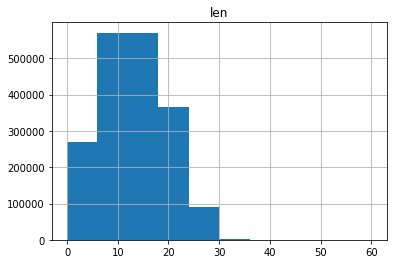

In [9]:
pd.DataFrame({'len':[len(_.split())for _ in data4['filter'].values]}).hist()

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel,AutoTokenizer,AutoConfig

In [9]:
origin_data = data4[data4.identification == 'train']
origin_data['label'] = [label2id[item] for item in origin_data['emotion'].values]

/home/ops/miniconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
train_data = origin_data.sample(frac=0.9)
test_data = origin_data[~origin_data.index.isin(train_data.index)]

In [11]:
# train_data.to_csv('tr.csv', index=None)
# test_data.to_csv('ts.csv', index=None)
# data4[data4.identification != 'train'].to_excel('test_data.xlsx',index=None)

In [12]:
print(train_data.shape)
print(test_data.shape)

(1310007, 6)
(145556, 6)


In [13]:
train_data.head()

,tweet_id,text,filter,identification,emotion,label
1820687,0x25c340,Bruhhhh I love <LH> and @IssaRae 😂😂😂 happy it'...,Bruhhhh I love and 😂😂😂 happy it's back,train,fear,5
896690,0x3055ac,First Friday of 1439! <LH>,First Friday of 1439!,train,joy,0
1475079,0x1fc37d,"I feel like this is a touchy subject, creative...","I feel like this is a touchy subject, creative...",train,sadness,3
911974,0x1fe204,"""A family where parents and children are allie...",A family where parents and children are allies...,train,joy,0
416500,0x24a313,Nothing more Pleasurable than seeing your coun...,Nothing more Pleasurable than seeing your coun...,train,joy,0


In [18]:
pretrained = '/home/ops/ptms_model/bert-large-uncased'
tokenizer = AutoTokenizer.from_pretrained(pretrained)

/home/ops/miniconda3/envs/torch/lib/python3.6/site-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


### 数据转换处理
--------
1. 通过bert tokenizer 将文本转变成input_ids，token_type_ids，attention_mask

In [19]:
# 数据处理
from tqdm import tqdm
import numpy as np
def get_x_y(df,max_len = 30):
    x1,x2,x3 =[],[],[]
    y = []
    for a in tqdm(df['filter'].values,total=df.shape[0]):
        encode = tokenizer.encode_plus(str(a),padding='max_length',truncation=True, max_length= max_len)
        x1.append(encode['input_ids'])
        x2.append(encode['token_type_ids'])
        x3.append(encode['attention_mask'])
    y = df.label.values
    return x1, x2, x3, y


In [16]:
train_x1,train_x2,train_x3, train_y = get_x_y(origin_data, 30)
test_x1,test_x2,test_x3, test_y = get_x_y(test_data, 30)


100%|██████████| 1455563/1455563 [04:24<00:00, 5510.15it/s]


### 定义模型
----------
1. 本实验采用两种bert预训练模型，以及textcnn分类模型进行实验
1. bert-large-uncased
1. bert-base-uncased
1. 离线模型下载地址：https://huggingface.co/models

最终large版本效果最佳，离线F1: 0.509%

#### 基于huggface的bert分类模型
![](https://pic1.zhimg.com/80/v2-edafe957e971fe53feeadd2477706cf4_720w.jpg)
#### 基于textcnn的分类模型
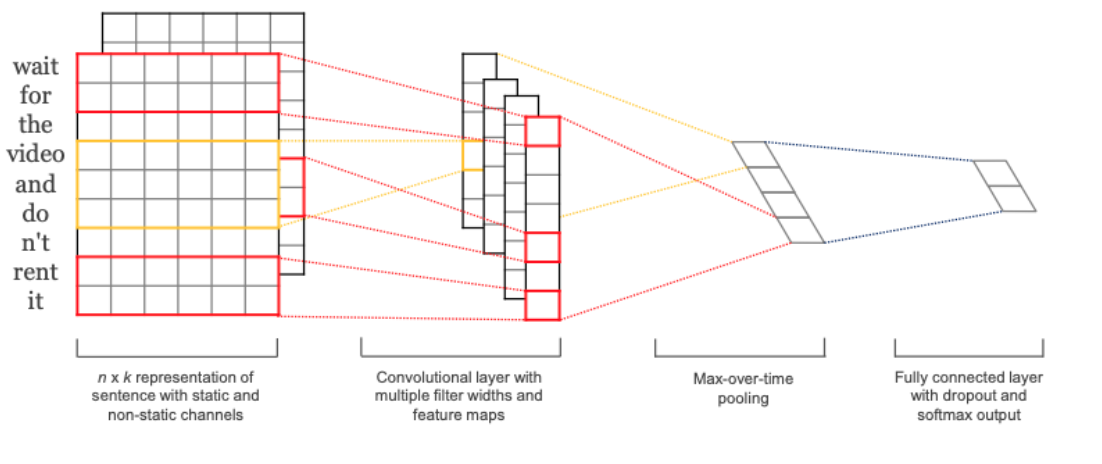

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import RandomSampler 


class DataDataset(Dataset):
    def __init__(self, x1,x2,x3, y):
        self.x1 = x1
        self.x2 = x2
        self.x3 = x3
        self.y = y
    
    def __getitem__(self, index):
        x1 = self.x1[index]
        x2 = self.x2[index]
        x3 = self.x3[index]
        y = self.y[index]
        return x1,x2,x3, y

    def __len__(self):
        return len(self.x1)

class textCNN(nn.Module):
    def __init__(self, args):
        super(textCNN, self).__init__()
        self.args = args
        
        Vocab = args.embed_num ## 已知词的数量
        Dim = args.embed_dim ##每个词向量长度
        Cla = args.class_num ##类别数
        Ci = 1 ##输入的channel数
        Knum = args.kernel_num ## 每种卷积核的数量
        Ks = args.kernel_sizes ## 卷积核list，形如[2,3,4]
        
        self.embed = nn.Embedding(Vocab,Dim) ## 词向量，这里直接随机
        
        self.convs = nn.ModuleList([nn.Conv2d(Ci,Knum,(K,Dim)) for K in Ks]) ## 卷积层
        self.dropout = nn.Dropout(args.dropout) 
        self.fc = nn.Linear(len(Ks)*Knum,Cla) ##全连接层
        
    def forward(self,x):
        x = self.embed(x)
        x = x.unsqueeze(1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(line,line.size(2)).squeeze(2) for line in x] 
        x = torch.cat(x,1)
        x = self.dropout(x)
        logit = self.fc(x)
        return logit
    

class EmoModel(torch.nn.Module):
    def __init__(self, pretrained, out):
        super(EmoModel, self).__init__()
        self.bert = AutoModel.from_pretrained(pretrained)
        self.linear = nn.Linear(self.bert.config.hidden_size, out)
    
    def forward(self,x1,x2,x3):
        encoder = self.bert(
            input_ids=x1,
            token_type_ids=x2,
            attention_mask=x3
            )[1]
        return self.linear(encoder)
    

### 改进1 Last 4 Layers Concatenating
-----------------------
优化trick 将 bert 最后4层学习到的信息进行叠加，最终进入分类层。

In [ ]:
class LastFourModel(nn.Module):
    
    def __init__(self, pretrained, out):
        super(LastFourModel, self).__init__()
        config = AutoConfig.from_pretrained(pretrained)
        config.update({'output_hidden_states':True})
        self.model = AutoModel.from_pretrained(pretrained, config=config)
        self.linear = nn.Linear(4*self.model.config.hidden_size, out)
        
    def forward(self, x1, x2, x3):
        
        outputs = self.model(
            input_ids=x1,
            token_type_ids=x2,
            attention_mask=x3)
        all_hidden_states = torch.stack(outputs[2])
        concatenate_pooling = torch.cat(
            (all_hidden_states[-1], all_hidden_states[-2], all_hidden_states[-3], all_hidden_states[-4]), -1
        )
        concatenate_pooling = concatenate_pooling[:,0]
        output = self.linear(concatenate_pooling)
        return output

### 改进2 模型层间差分学习率
---------------
1. 参数设定为：parameters=get_parameters(rnn,2e-5,0.95, 1e-5) 
2. 起始层数学习率较大，伴随着层数增大而随之减少（本实验采用0.95的衰减速率）
3. 优化模型收敛速度，尤其是在large版本

In [ ]:
def get_parameters(model, model_init_lr, multiplier, classifier_lr):
    parameters = []
    lr = model_init_lr
    for layer in range(12,-1,-1):
        layer_params = {
            'params': [p for n,p in model.named_parameters() if f'encoder.layer.{layer}.' in n],
            'lr': lr
        }
        parameters.append(layer_params)
        lr *= multiplier
    classifier_params = {
        'params': [p for n,p in model.named_parameters() if 'layer_norm' in n or 'linear' in n 
                   or 'pooling' in n],
        'lr': classifier_lr
    }
    parameters.append(classifier_params)
    return parameters


In [22]:
atrain_x1 = np.array(train_x1)
atrain_x2 = np.array(train_x2)
atrain_x3 = np.array(train_x3)
atrain_y = np.array(train_y)
atest_x1 = np.array(test_x1)
atest_x2 = np.array(test_x2)
atest_x3 = np.array(test_x3)
atest_y = np.array(test_y)

### 模型训练
--------
1. batch_size: 160 (gpu显存限制)
2. epochs：10
3. 通过torch DataLoader 加载数据
4. 记录最佳acc，并且保存acc最高的模型

tips：遗憾点本次实验应当采用F1而不是acc作为模型效果的评判。

In [ ]:
batch_size = 160
num_epochs = 10
learning_rate = 2e-5
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

train_datasets = DataDataset(atrain_x1,atrain_x2,atrain_x3, atrain_y)
test_datasets = DataDataset(atest_x1,atest_x2,atest_x3, atest_y)
train_loader = torch.utils.data.DataLoader(dataset=train_datasets,
                                           batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_datasets,
                                          batch_size=batch_size,shuffle=True)

rnn = EmoModel(pretrained,len(label2id)).to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(rnn.parameters(),lr=learning_rate)
parameters=get_parameters(rnn,2e-5,0.95, 1e-5)
optimizer=torch.optim.AdamW(parameters)

losses = []
best_acc = 0
for epoch in range(num_epochs):
    epoch_loss = 0.
    for i,(x1,x2,x3,y) in enumerate(train_loader):
        x1 = x1.long().to(device)
        x2 = x2.long().to(device)
        x3 = x3.long().to(device)
        y = y.long().to(device)
        optimizer.zero_grad()
        outputs = rnn(x1,x2,x3)
        loss = criterion(outputs,y)
        loss.backward()
        optimizer.step()
        if i % 30 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))
        epoch_loss += float(loss.item())
 
    losses.append(epoch_loss / len(train_loader))
    torch.save(rnn.state_dict(), 'models/v10_{}_final_model.pt'.format(epoch))
    correct = 0
    with torch.no_grad():
        for x1,x2,x3, y in test_loader:
            rnn.eval()
            x1 = x1.long().to(device)
            x2 = x2.long().to(device)
            x3 = x3.long().to(device)
            y = y.long().to(device)
            pre = rnn(x1,x2,x3)
            pred = pre.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(y.view_as(pred)).sum().item()
 
        test_acc = correct / len(test_loader.dataset)
        if best_acc < test_acc:
            best_acc = test_acc
            torch.save(rnn.state_dict(), 'models/v7best_model_{}.pt'.format(best_acc))
        print('best_acc',best_acc)
    
torch.save(rnn.state_dict(), 'models/final_model.pt')

Some weights of the model checkpoint at /home/ops/ptms_model/bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch [1/10], Step [1/9098], Loss: 2.4803
Epoch [1/10], Step [31/9098], Loss: 1.7635
Epoch [1/10], Step [61/9098], Loss: 1.6436
Epoch [1/10], Step [91/9098], Loss: 1.5165
Epoch [1/10], Step [121/9098], Loss: 1.5815
Epoch [1/10], Step [151/9098], Loss: 1.4819
Epoch [1/10], Step [181/9098], Loss: 1.4616
Epoch [1/10], Step [211/9098], Loss: 1.4782
Epoch [1/10], Step [241/9098], Loss: 1.4279
Epoch [1/10], Step [271/9098], Loss: 1.3910
Epoch [1/10], Step [301/9098], Loss: 1.3532
Epoch [1/10], Step [331/9098], Loss: 1.3489
Epoch [1/10], Step [361/9098], Loss: 1.3943
Epoch [1/10], Step [391/9098], Loss: 1.3678
Epoch [1/10], Step [421/9098], Loss: 1.3439
Epoch [1/10], Step [451/9098], Loss: 1.4949
Epoch [1/10], Step [481/9098], Loss: 1.3016
Epoch [1/10], Step [511/9098], Loss: 1.3238
Epoch [1/10], Step [541/9098], Loss: 1.4512
Epoch [1/10], Step [571/9098], Loss: 1.3134
Epoch [1/10], Step [601/9098], Loss: 1.4977
Epoch [1/10], Step [691/9098], Loss: 1.2878
Epoch [1/10], Step [721/9098], Loss: 

### 模型预测
-------
1. 选取训练时，验证集效果最好的模型进行预测
2. 通过load_state_dict方法加载模型

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EmoModel(pretrained,len(label2id)).to(device)
model.load_state_dict(torch.load('models/v4best_model_0.5752768693836049.pt'))

Some weights of the model checkpoint at /home/ops/ptms_model/bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

### 读取测试数据
-------
类似于训练数据，通过tokenizer 转化为input_ids，token_type_ids，attention_mask

In [ ]:
test_data = pd.read_excel('test_data.xlsx')

In [ ]:
# 数据处理
from tqdm import tqdm
import numpy as np
def get_x_y(df,max_len = 30):
    x1,x2,x3 =[],[],[]
    for a in tqdm(df['filter'].values,total=df.shape[0]):
        encode = tokenizer.encode_plus(str(a),padding='max_length',truncation=True, max_length= max_len)
        x1.append(encode['input_ids'])
        x2.append(encode['token_type_ids'])
        x3.append(encode['attention_mask'])
    return x1, x2, x3
tx1, tx2, tx3 = get_x_y(test_data)
tx1, tx2, tx3 = np.array(tx1),np.array(tx2),np.array(tx3)

### 测试推理并保存文件
-------

In [ ]:
batch_size = 1024

test_datasets = DataDataset(tx1, tx2, tx3)
test_loader = torch.utils.data.DataLoader(dataset=test_datasets,
                                          batch_size=batch_size,shuffle=False
                                         )
emotion = []
model.eval()

with torch.no_grad():
    for x1,x2,x3 in tqdm(test_loader):
        x1 = x1.long().to(device)
        x2 = x2.long().to(device)
        x3 = x3.long().to(device)
        pre = model(x1,x2,x3)
        pred = pre.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        z = [id2label[item] for item in pred.cpu().numpy().reshape(-1,)]
        emotion.extend(z)
    
result = test_data[['tweet_id']]
result['emotion'] = emotion
result.columns = ['id','emotion']
result.to_csv('test_reslut9.csv',index=None)